In [1]:
import numpy as np
#import multiprocessing as mp
#import ipyparallel as ipp
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.size': 14})
import vegas
from scipy.integrate import quad
from scipy.interpolate import interp1d
from functools import partial

In [2]:
# Import DSNB BDM flux for mx = 1 MeV and sigma_xv = 1e-35cm^2
fluxGC_data = np.loadtxt('data/dsnbBDM_flux_mx1MeV_1e-35cm2_GC.txt',skiprows=1)
fluxAvg_data = np.loadtxt('data/dsnbBDM_flux_mx1MeV_1e-35cm2_Average.txt',skiprows=1)

# do interpolation
fluxGC = interp1d(fluxGC_data.T[0],fluxGC_data.T[1])
fluxAvg = interp1d(fluxAvg_data.T[0],fluxAvg_data.T[1])

# make a function
def dsnbFluxGC(Tx,mx=1,sigma=1e-35):
    """
    Return DSNB BDM flux in terms of SN at GC for all galaxies
    
    Input
    ------
    Tx: BDM observed kinetic energy on Earth, MeV
    mx: DM mass, default 1 MeV
    sigma: DM-neutrino cross section, default 1e-35 cm^2
    
    Output
    ------
    flux: per MeV per cm^2 per second
    """
    return fluxGC(Tx)/mx*sigma/1e-35

def dsnbFluxAvg(Tx,mx=1,sigma=1e-35):
    """
    Return DSNB BDM flux in terms of SN average overall the stellar disc
    
    Input
    ------
    Tx: BDM observed kinetic energy on Earth, MeV
    mx: DM mass, default 1 MeV
    sigma: DM-neutrino cross section, default 1e-35 cm^2
    
    Output
    ------
    flux: per MeV per cm^2 per second
    """
    return fluxAvg(Tx)/mx*sigma/1e-35

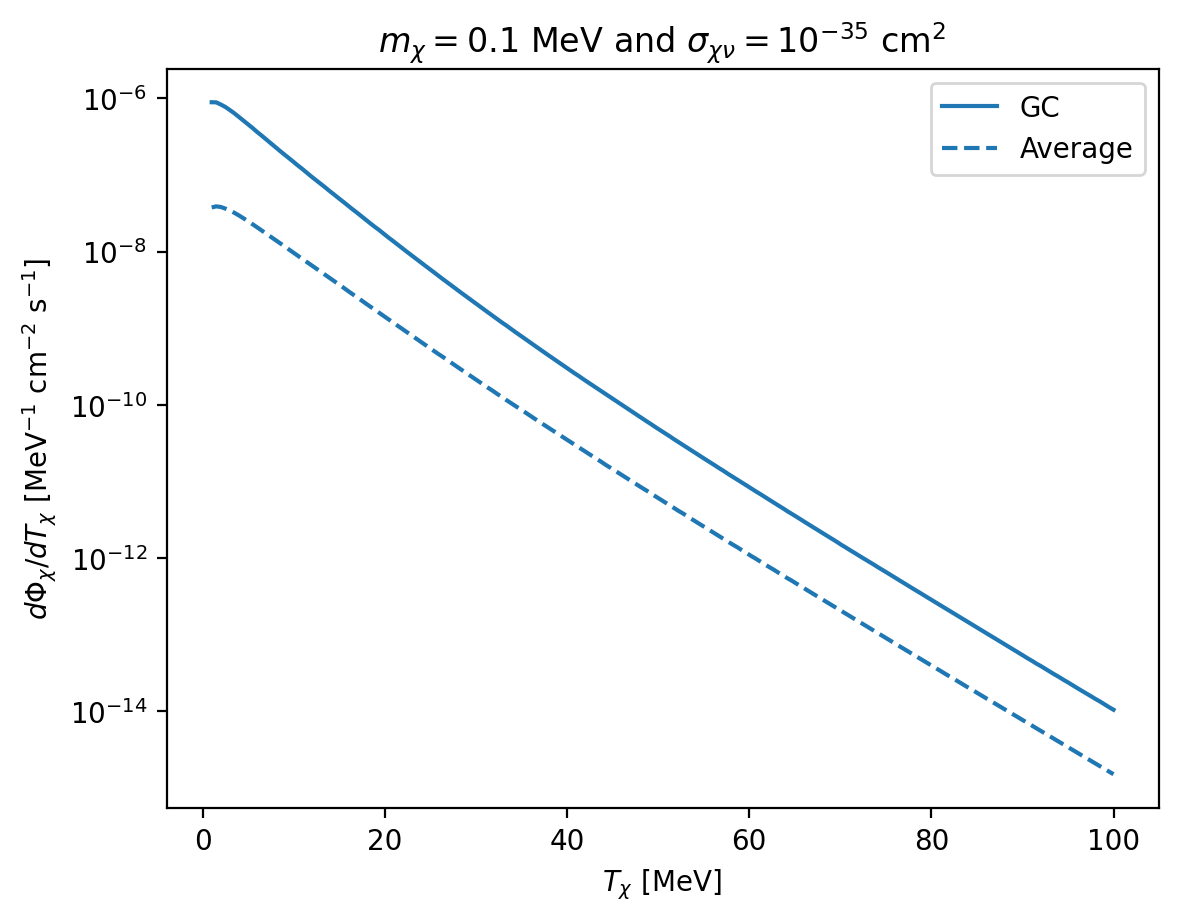

In [3]:
TxList = np.linspace(1,100,200)
mx = 0.1
plt.plot(TxList,dsnbFluxGC(TxList,mx=mx),color='C0',label='GC')
plt.plot(TxList,dsnbFluxAvg(TxList,mx=mx),'--',color='C0',label='Average')
plt.legend()
#plt.xlim(0,100)
plt.yscale('log')
plt.xlabel(r'$T_\chi~{\rm [MeV]}$ ')
plt.ylabel(r'$d\Phi_\chi/dT_\chi~{\rm [MeV^{-1}~cm^{-2}~s^{-1}]}$')
plt.title(r'$m_\chi=0.1~{\rm MeV}~{\rm and}~\sigma_{\chi\nu}=10^{-35}~{\rm cm^{2}}$')
plt.show()

In [4]:
# Background event
def bkgEvent(t):
    """
    Total background event in Super-K, Hyper-K and DUNE for a given exposure time
    
    Input
    ------
    t: exposure time, years
    
    Output
    ------
    tup: background event numbers in (SK,HK,DUNE)
    """
    return 526*22.2*t,526*222*t,427*17*t

# DSNB event per year per electron for mx = 1 MeV and sigma_xe = 1e-35 cm^2
eventGC = 6.40864e-35
eventAvg = 4.13846e-36 

def dsnbBDMEvent(t,mx,sigxe=1e-35,sigxv=1e-35):
    """
    Total DSNB BDM event in Super-K, Hyper-K and DUNE for a given exposure time
    
    Input
    ------
    t: exposure time, years
    mx: DM mass, MeV
    sigxe: DM-electron cross section, default 1e-35 cm^2
    sigxv: DM-neutrino cross section, default 1e-35 cm^2
    
    Output
    ------
    2Darray: event GC, eventAvg
    """
    NeSK = 7.34e33
    NeHK = 7.34e34
    NeDUNE = 4.58e33
    # GC
    eventGCSK = t*NeSK*eventGC*(sigxe/1e-35)*(sigxv/1e-35)/mx
    eventGCHK = t*NeHK*eventGC*(sigxe/1e-35)*(sigxv/1e-35)/mx
    eventGCDUNE = t*NeDUNE*eventGC*(sigxe/1e-35)*(sigxv/1e-35)/mx
    arrayGC = np.array([eventGCSK,eventGCHK,eventGCDUNE])
    # Average
    eventAvgSK = t*NeSK*eventAvg*(sigxe/1e-35)*(sigxv/1e-35)/mx
    eventAvgHK = t*NeHK*eventAvg*(sigxe/1e-35)*(sigxv/1e-35)/mx
    eventAvgDUNE = t*NeDUNE*eventAvg*(sigxe/1e-35)*(sigxv/1e-35)/mx
    arrayAvg = np.array([eventAvgSK,eventAvgHK,eventAvgDUNE])
    return np.vstack((arrayGC,arrayAvg))

Given the sensitivity equation
\begin{equation}
N_\sigma=\frac{N_\chi}{\sqrt{N_\chi+N_b}} \label{eq:sensitivity}
\end{equation}
where $N_\sigma$ is the detection signficance, $N_{\chi,b}$ are BDM and background events respectively.
Assuming $\sigma_{\chi\nu}=\sigma_{\chi e}=\sigma_0$ and $t_{\rm exp}$ the exposure time in year, we rewrite them as
\begin{equation}
N_\chi = N_{\chi,0} t_{\rm exp}\left(\frac{\sigma_0^2}{10^{-70}\,{\rm cm^4}}\right)~{\rm and}~N_b = N_{b,0}t_{\rm exp}
\end{equation}
where $N_{\chi,0}$ is the BDM event per year in a given detector with $\sigma_0=10^{-35}~{\rm cm}^2$ and $N_{b,0}$ is the background event per year in a give detector.

Eq. $\eqref{eq:sensitivity}$ yields,
\begin{equation}
N_\chi = \frac{N_\sigma}{2}(1 +\sqrt{4N_b +N_\sigma^2})
\end{equation}
or
\begin{equation}
\sigma_0 = 10^{-35}~{\rm cm}^2~ \left[\frac{N_\sigma}{2N_{\chi,0}t_{\rm exp}}\left(1 +\sqrt{4N_{b,0}t_{\rm exp} +N_\sigma^2}\right)\right]^{1/2}.
\end{equation}

In [6]:
def sensitivitySigma0(ns,t,mx):
    [Nx0SK_GC,Nx0HK_GC,Nx0DUNE_GC],[Nx0SK_Avg,Nx0HK_Avg,Nx0DUNE_Avg] = dsnbBDMEvent(1,mx,sigxe=1e-35,sigxv=1e-35)
    Nb0SK,Nb0HK,Nb0DUNE = bkgEvent(1)
    def _s0(ns,t,Nx0,Nb0):
        return np.sqrt(ns*(1 + np.sqrt(4*Nb0*t + ns**2))/2/Nx0/t)*1e-35
    
    return _s0(ns,t,Nx0SK_GC,Nb0SK),_s0(ns,t,Nx0HK_GC,Nb0HK),_s0(ns,t,Nx0DUNE_GC,Nb0DUNE), \
           _s0(ns,t,Nx0SK_Avg,Nb0SK),_s0(ns,t,Nx0HK_Avg,Nb0HK),_s0(ns,t,Nx0DUNE_Avg,Nb0DUNE)

In [7]:
mxList = np.logspace(-6,1,50)
# 2sigma in 5 years
ns = 2
texp = 5
# empty lists for storing constraints
senSK_GC = []
senHK_GC = []
senDUNE_GC = []
senSK_Avg = []
senHK_Avg = []
senDUNE_Avg = []
for mx in mxList:
    sk_gc,hk_gc,dune_gc,sk_avg,hk_avg,dune_avg = sensitivitySigma0(ns,texp,mx)
    senSK_GC.append(sk_gc)
    senHK_GC.append(hk_gc)
    senDUNE_GC.append(dune_gc)
    senSK_Avg.append(sk_avg)
    senHK_Avg.append(hk_avg)
    senDUNE_Avg.append(dune_avg)

In [8]:
constraintPath = '../SNvBDM/constraints/'
constraintSNvBDMPath = '../SNvBDM/constraints/ours/'
# load file
oursMW_SK = np.loadtxt(constraintSNvBDMPath + 'MW_SK.txt')
oursMW_HK = np.loadtxt(constraintSNvBDMPath + 'MW_HK.txt')
oursLMC = np.loadtxt(constraintSNvBDMPath + 'LMC.txt')
constDD = 10**np.loadtxt(constraintPath + 'direct_search.txt')
constCRBDM = 10**np.loadtxt(constraintPath + 'ema_superK.txt')
constSolarRef = 10**np.loadtxt(constraintPath + 'solar_reflection.txt')

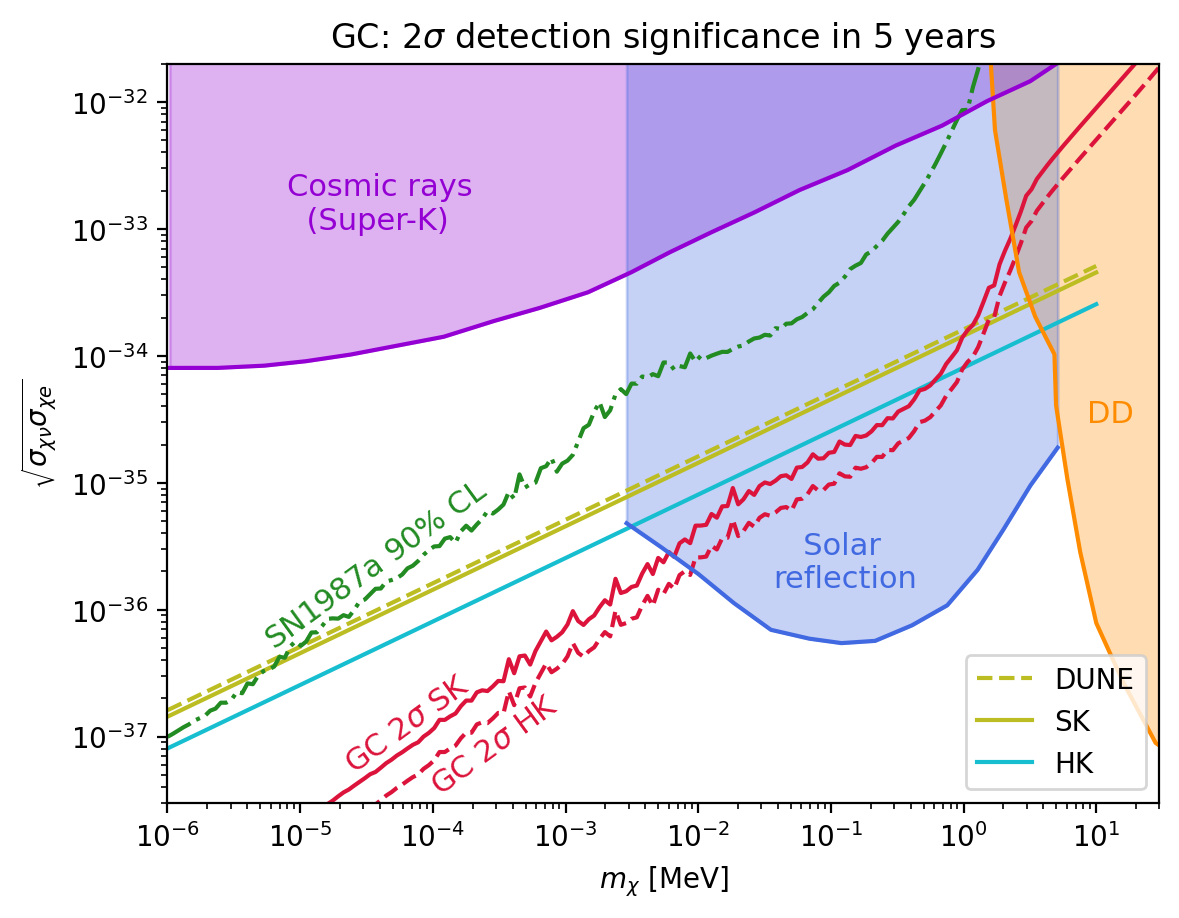

In [71]:
plt.plot(mxList,senDUNE_GC,'--',color='C8',label='DUNE')
plt.plot(mxList,senSK_GC,color='C8',label='SK')
plt.plot(mxList,senHK_GC,color='C9',label='HK')

# Our previous SNvBDM constraints
plt.plot(oursMW_SK.T[0],oursMW_SK.T[1],color='crimson')
plt.text(2e-5, 5.2e-38,r'GC $2\sigma$ SK',rotation=36, color = 'crimson',fontsize=11)

plt.plot(oursMW_HK.T[0],oursMW_HK.T[1],'--',color='crimson')
plt.text(9e-5, 3.5e-38,r'GC $2\sigma$ HK',rotation=36, color = 'crimson',fontsize=11)

plt.plot(oursLMC.T[0],oursLMC.T[1],'-.',color='forestgreen')
plt.text(5e-6, 5e-37,r'SN1987a $90\%~{\rm CL}$',rotation=36, color = 'forestgreen',fontsize=11)

# Existing constraints
plt.plot(constDD.T[0],constDD.T[1], color='darkorange')
plt.fill_between(constDD.T[0], constDD.T[1],1e-31,alpha=0.3, color='darkorange')
plt.text(8.5, 3e-35,'DD', color = 'darkorange',fontsize=11)

plt.plot(constCRBDM.T[0],constCRBDM.T[1], color='darkviolet')
plt.fill_between(constCRBDM.T[0], constCRBDM.T[1],1e-31,alpha=0.3, color='darkviolet')
plt.text(8e-6, 1e-33,'Cosmic rays\n  (Super-K)', color = 'darkviolet',fontsize=11)

plt.plot(constSolarRef.T[0],constSolarRef.T[1],color='royalblue')
plt.fill_between(constSolarRef.T[0], constSolarRef.T[1],1e-31,alpha=0.3,color='royalblue')
plt.text(3.7e-2, 1.5e-36,'   Solar\nreflection', color = 'royalblue',fontsize=11)

# Other figure setup
plt.xlim(1e-6,30)
plt.ylim(3e-38,2e-32)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_\chi~[{\rm MeV}]$')
plt.ylabel(r'$\sqrt{\sigma_{\chi\nu}\sigma_{\chi e}}$')
plt.title(r'GC: $2\sigma$ detection significance in 5 years')
plt.legend(loc='lower right')
plt.savefig('figures/sensitivityGC_texp5.pdf',bbox_inches='tight')
plt.show()

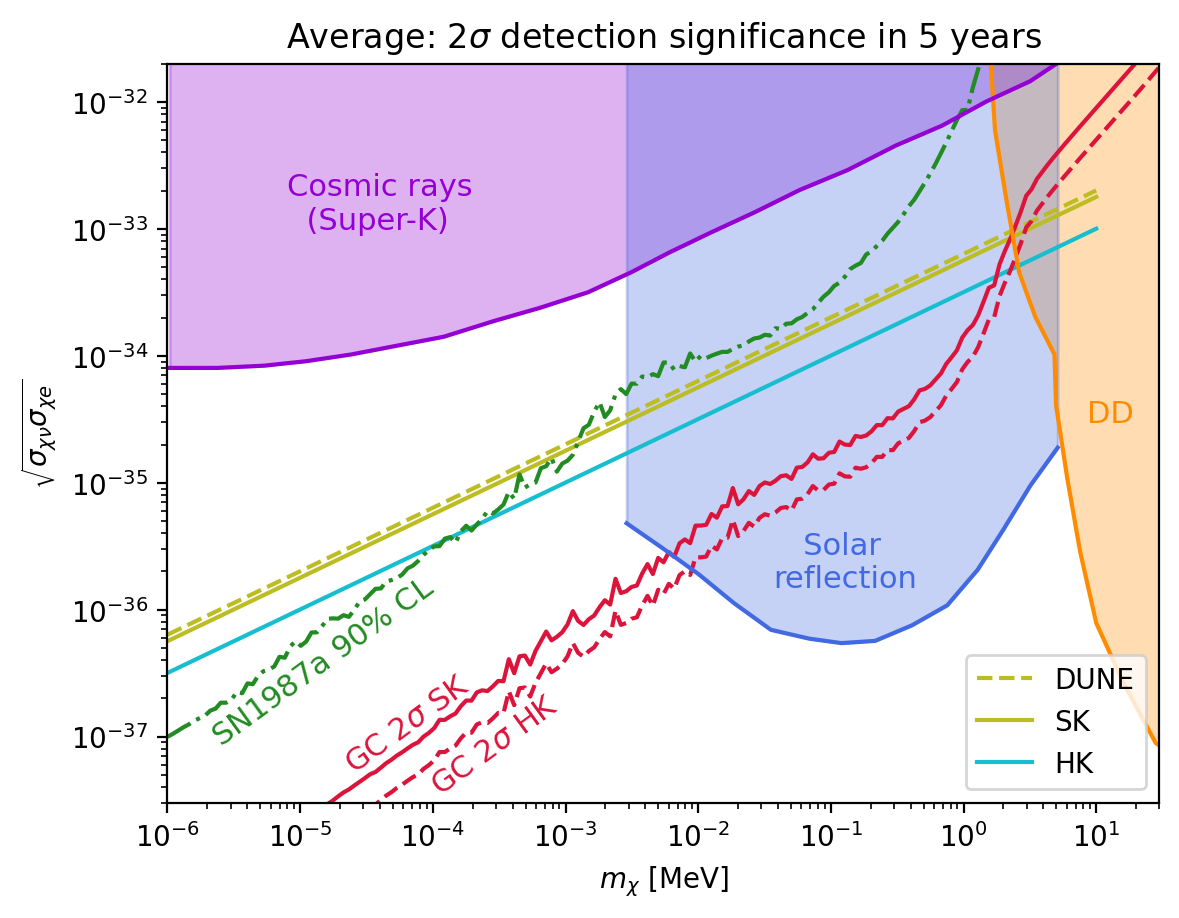

In [72]:
plt.plot(mxList,senDUNE_Avg,'--',color='C8',label='DUNE')
plt.plot(mxList,senSK_Avg,color='C8',label='SK')
plt.plot(mxList,senHK_Avg,color='C9',label='HK')

# Our previous SNvBDM constraints
plt.plot(oursMW_SK.T[0],oursMW_SK.T[1],color='crimson')
plt.text(2e-5, 5.2e-38,r'GC $2\sigma$ SK',rotation=36, color = 'crimson',fontsize=11)

plt.plot(oursMW_HK.T[0],oursMW_HK.T[1],'--',color='crimson')
plt.text(9e-5, 3.5e-38,r'GC $2\sigma$ HK',rotation=36, color = 'crimson',fontsize=11)

plt.plot(oursLMC.T[0],oursLMC.T[1],'-.',color='forestgreen')
plt.text(2e-6, 8.6e-38,r'SN1987a $90\%~{\rm CL}$',rotation=36, color = 'forestgreen',fontsize=11)

# Existing constraints
plt.plot(constDD.T[0],constDD.T[1], color='darkorange')
plt.fill_between(constDD.T[0], constDD.T[1],1e-31,alpha=0.3, color='darkorange')
plt.text(8.5, 3e-35,'DD', color = 'darkorange',fontsize=11)

plt.plot(constCRBDM.T[0],constCRBDM.T[1], color='darkviolet')
plt.fill_between(constCRBDM.T[0], constCRBDM.T[1],1e-31,alpha=0.3, color='darkviolet')
plt.text(8e-6, 1e-33,'Cosmic rays\n  (Super-K)', color = 'darkviolet',fontsize=11)

plt.plot(constSolarRef.T[0],constSolarRef.T[1],color='royalblue')
plt.fill_between(constSolarRef.T[0], constSolarRef.T[1],1e-31,alpha=0.3,color='royalblue')
plt.text(3.7e-2, 1.5e-36,'   Solar\nreflection', color = 'royalblue',fontsize=11)

# Other figure setup
plt.xlim(1e-6,30)
plt.ylim(3e-38,2e-32)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_\chi~[{\rm MeV}]$')
plt.ylabel(r'$\sqrt{\sigma_{\chi\nu}\sigma_{\chi e}}$')
plt.title(r'Average: $2\sigma$ detection significance in 5 years')
plt.legend(loc='lower right')
plt.savefig('figures/sensitivityAvg_texp5.pdf',bbox_inches='tight')
plt.show()

In [70]:
mxList = np.logspace(-6,1,50)
# 2sigma in 5 years
ns = 2
texp = 10
# empty lists for storing constraints
senSK_GC_texp10 = []
senHK_GC_texp10 = []
senDUNE_GC_texp10 = []
senSK_Avg_texp10 = []
senHK_Avg_texp10 = []
senDUNE_Avg_texp10 = []
for mx in mxList:
    sk_gc,hk_gc,dune_gc,sk_avg,hk_avg,dune_avg = sensitivitySigma0(ns,texp,mx)
    senSK_GC_texp10.append(sk_gc)
    senHK_GC_texp10.append(hk_gc)
    senDUNE_GC_texp10.append(dune_gc)
    senSK_Avg_texp10.append(sk_avg)
    senHK_Avg_texp10.append(hk_avg)
    senDUNE_Avg_texp10.append(dune_avg)

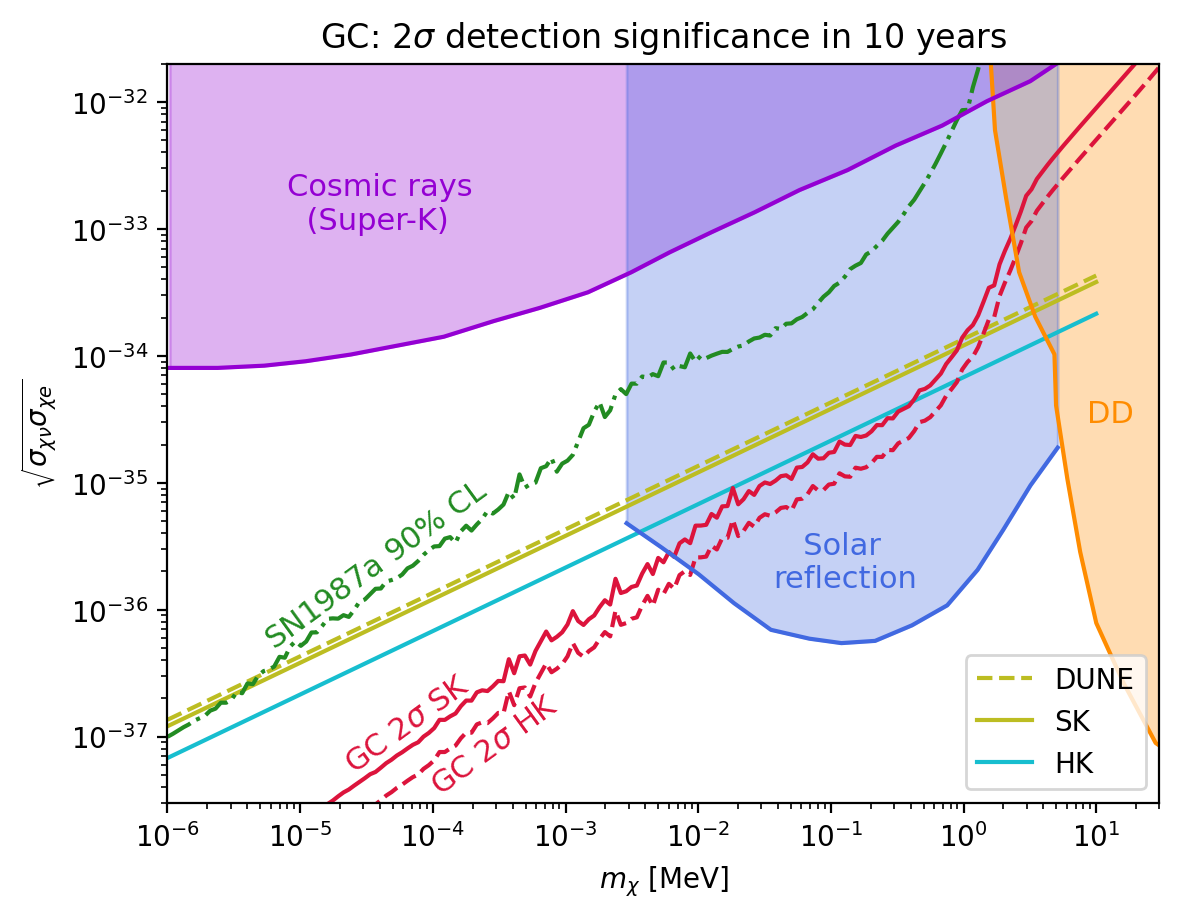

In [75]:
plt.plot(mxList,senDUNE_GC_texp10,'--',color='C8',label='DUNE')
plt.plot(mxList,senSK_GC_texp10,color='C8',label='SK')
plt.plot(mxList,senHK_GC_texp10,color='C9',label='HK')

# Our previous SNvBDM constraints
plt.plot(oursMW_SK.T[0],oursMW_SK.T[1],color='crimson')
plt.text(2e-5, 5.2e-38,r'GC $2\sigma$ SK',rotation=36, color = 'crimson',fontsize=11)

plt.plot(oursMW_HK.T[0],oursMW_HK.T[1],'--',color='crimson')
plt.text(9e-5, 3.5e-38,r'GC $2\sigma$ HK',rotation=36, color = 'crimson',fontsize=11)

plt.plot(oursLMC.T[0],oursLMC.T[1],'-.',color='forestgreen')
plt.text(5e-6, 5e-37,r'SN1987a $90\%~{\rm CL}$',rotation=36, color = 'forestgreen',fontsize=11)

# Existing constraints
plt.plot(constDD.T[0],constDD.T[1], color='darkorange')
plt.fill_between(constDD.T[0], constDD.T[1],1e-31,alpha=0.3, color='darkorange')
plt.text(8.5, 3e-35,'DD', color = 'darkorange',fontsize=11)

plt.plot(constCRBDM.T[0],constCRBDM.T[1], color='darkviolet')
plt.fill_between(constCRBDM.T[0], constCRBDM.T[1],1e-31,alpha=0.3, color='darkviolet')
plt.text(8e-6, 1e-33,'Cosmic rays\n  (Super-K)', color = 'darkviolet',fontsize=11)

plt.plot(constSolarRef.T[0],constSolarRef.T[1],color='royalblue')
plt.fill_between(constSolarRef.T[0], constSolarRef.T[1],1e-31,alpha=0.3,color='royalblue')
plt.text(3.7e-2, 1.5e-36,'   Solar\nreflection', color = 'royalblue',fontsize=11)

# Other figure setup
plt.xlim(1e-6,30)
plt.ylim(3e-38,2e-32)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_\chi~[{\rm MeV}]$')
plt.ylabel(r'$\sqrt{\sigma_{\chi\nu}\sigma_{\chi e}}$')
plt.title(r'GC: $2\sigma$ detection significance in 10 years')
plt.legend(loc='lower right')
plt.savefig('figures/sensitivityGC_texp10.pdf',bbox_inches='tight')
plt.show()

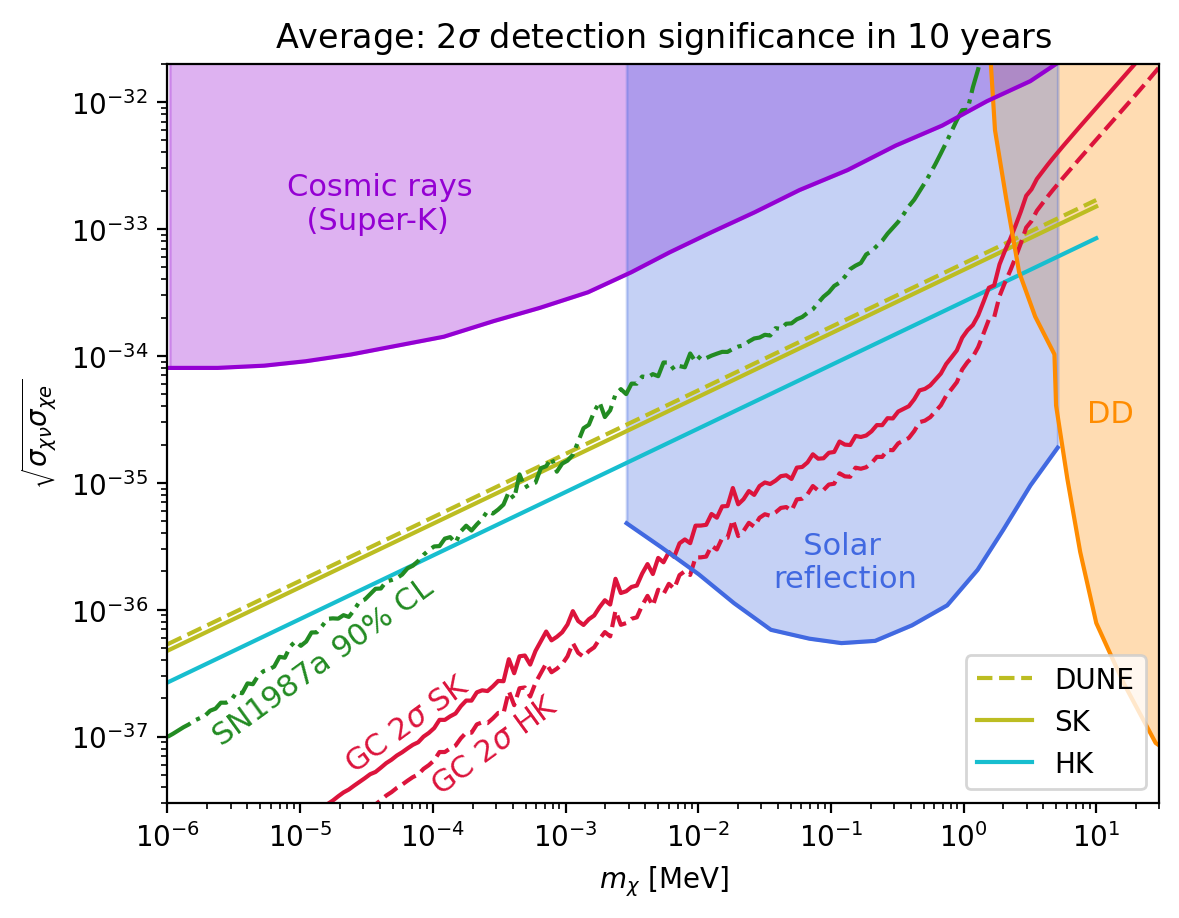

In [78]:
plt.plot(mxList,senDUNE_Avg_texp10,'--',color='C8',label='DUNE')
plt.plot(mxList,senSK_Avg_texp10,color='C8',label='SK')
plt.plot(mxList,senHK_Avg_texp10,color='C9',label='HK')

# Our previous SNvBDM constraints
plt.plot(oursMW_SK.T[0],oursMW_SK.T[1],color='crimson')
plt.text(2e-5, 5.2e-38,r'GC $2\sigma$ SK',rotation=36, color = 'crimson',fontsize=11)

plt.plot(oursMW_HK.T[0],oursMW_HK.T[1],'--',color='crimson')
plt.text(9e-5, 3.5e-38,r'GC $2\sigma$ HK',rotation=36, color = 'crimson',fontsize=11)

plt.plot(oursLMC.T[0],oursLMC.T[1],'-.',color='forestgreen')
plt.text(2e-6, 8.6e-38,r'SN1987a $90\%~{\rm CL}$',rotation=36, color = 'forestgreen',fontsize=11)

# Existing constraints
plt.plot(constDD.T[0],constDD.T[1], color='darkorange')
plt.fill_between(constDD.T[0], constDD.T[1],1e-31,alpha=0.3, color='darkorange')
plt.text(8.5, 3e-35,'DD', color = 'darkorange',fontsize=11)

plt.plot(constCRBDM.T[0],constCRBDM.T[1], color='darkviolet')
plt.fill_between(constCRBDM.T[0], constCRBDM.T[1],1e-31,alpha=0.3, color='darkviolet')
plt.text(8e-6, 1e-33,'Cosmic rays\n  (Super-K)', color = 'darkviolet',fontsize=11)

plt.plot(constSolarRef.T[0],constSolarRef.T[1],color='royalblue')
plt.fill_between(constSolarRef.T[0], constSolarRef.T[1],1e-31,alpha=0.3,color='royalblue')
plt.text(3.7e-2, 1.5e-36,'   Solar\nreflection', color = 'royalblue',fontsize=11)

# Other figure setup
plt.xlim(1e-6,30)
plt.ylim(3e-38,2e-32)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_\chi~[{\rm MeV}]$')
plt.ylabel(r'$\sqrt{\sigma_{\chi\nu}\sigma_{\chi e}}$')
plt.title(r'Average: $2\sigma$ detection significance in 10 years')
plt.legend(loc='lower right')
plt.savefig('figures/sensitivityAvg_texp10.pdf',bbox_inches='tight')
plt.show()